In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("hotel_bookings.csv")

## 2.1 Cramer's V for categorical features

In [2]:
df=df.drop('reservation_status',axis=1)

In [3]:
df['is_canceled']=df['is_canceled'].replace([0,1],["no","yes"])

In [4]:
#Extracting categorical feature columns
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))

In [5]:
df_cat=df[cat_cols]

In [6]:
df_cat.columns

Index(['deposit_type', 'hotel', 'country', 'meal', 'is_canceled',
       'distribution_channel', 'assigned_room_type', 'arrival_date_month',
       'customer_type', 'market_segment', 'reserved_room_type',
       'reservation_status_date'],
      dtype='object')

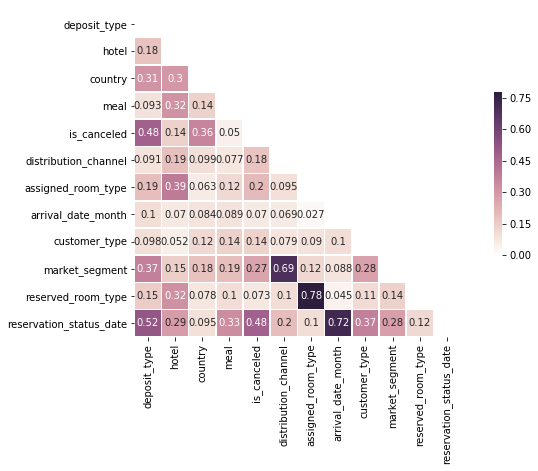

In [7]:
import itertools
import scipy

def cramers_corrected_stat(confusion_matrix):
    """
    Calculates the corrected Cramer's V statistic
    
    Args:
        confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
    Returns:
        The corrected Cramer's V statistic
    """
    
    #chi2, _, _, _ = scipy.stats.chi2_contingency(confusion_matrix)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

#Getting the list of columns in the dataframe
cols = list(df_cat.columns.values)

#Creating an empty array to append to as we will go through iteratations to calculate correlations of every combination of variables.
emp_arr = np.zeros((len(cols),len(cols)))

#Iteraiting dataframe using itertools
#itertools.combinations() : Given an array of size n, generate and print all possible combinations of r elements in array.
for col1, col2 in itertools.combinations(cols, 2):
    A, B = df_cat[col1], df_cat[col2]
    idx1, idx2 = cols.index(col1), cols.index(col2)
    conf_mat = pd.crosstab(A,B) 
    #appending results to emp_array
    emp_arr[idx1, idx2] = cramers_corrected_stat(conf_mat.values)
    emp_arr[idx2, idx1] = emp_arr[idx1, idx2]

#creating a correlation matrix
corr = pd.DataFrame(emp_arr, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(12, 6))

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## 2.2 Correlation for numerical features

Let's quickly glance at numerical features's correlations. Before that we need to re-convert "is_canceled" attribute to numerical values.

In [8]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,Resort Hotel,no,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,no,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,no,7,2015,July,27,1,0,1,1,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,2015-07-02
3,Resort Hotel,no,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,2015-07-02
4,Resort Hotel,no,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,2015-07-03


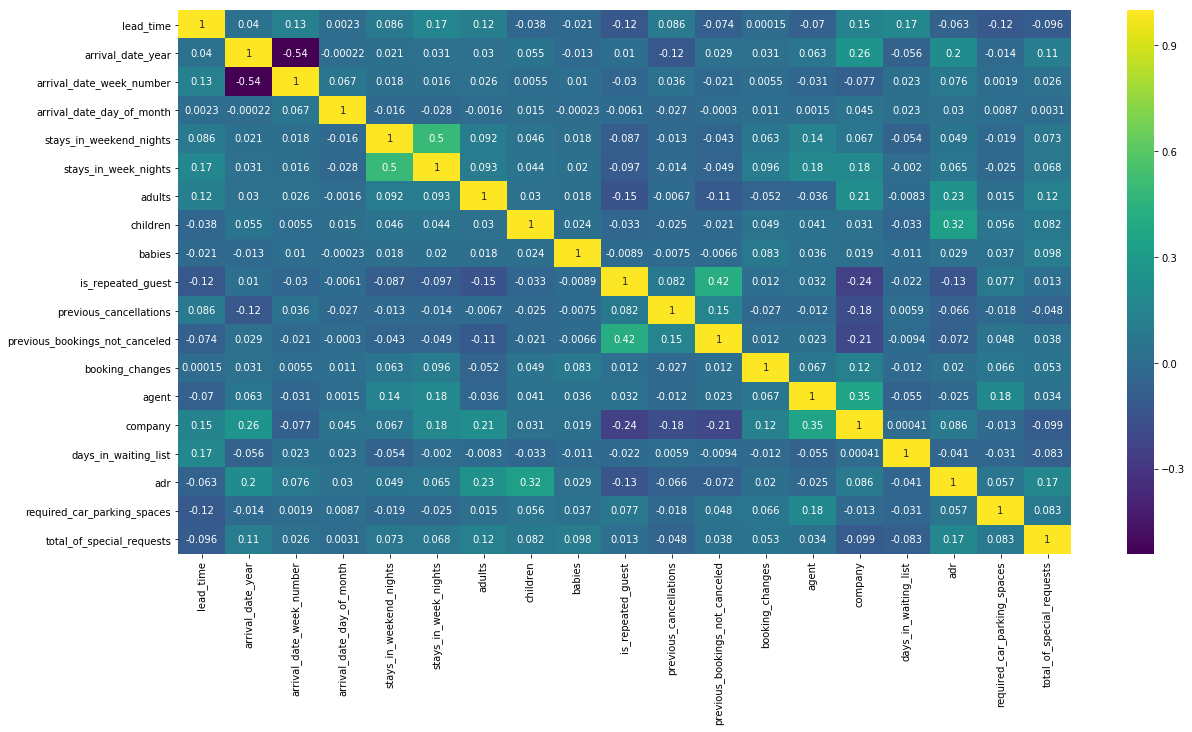

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

The leadtime attribute had the strongest linear correlation with cancellation.

Let's look at the correlation values in a bar graph.

We can more clearly see that both lead_time and total_of_special_requests had the strongest linear correlations with is_canceled target variable.

# 3. Dimensionality reduction : PCA & TSNE

## 3.1 Categorical features only

Now I want to run PCA analysis on categorical features to see if we can really reduce our dataset dimensionality. For PCA to run effectively, let's convert categorical features to numerical ones using Scikit-learn. This requires running integer encoding first follwed by OneHotEncoding.

In [10]:
# Separate features and predicted value
X_cat = df_cat.drop("is_canceled", axis=1)
y_cat = df_cat["is_canceled"].eq('yes').mul(1)

In [11]:
X_cat.head()

,deposit_type,hotel,country,meal,distribution_channel,assigned_room_type,arrival_date_month,customer_type,market_segment,reserved_room_type,reservation_status_date
0,No Deposit,Resort Hotel,PRT,BB,Direct,C,July,Transient,Direct,C,2015-07-01
1,No Deposit,Resort Hotel,PRT,BB,Direct,C,July,Transient,Direct,C,2015-07-01
2,No Deposit,Resort Hotel,GBR,BB,Direct,C,July,Transient,Direct,A,2015-07-02
3,No Deposit,Resort Hotel,GBR,BB,Corporate,A,July,Transient,Corporate,A,2015-07-02
4,No Deposit,Resort Hotel,GBR,BB,TA/TO,A,July,Transient,Online TA,A,2015-07-03


In [12]:
X_cat['country'].fillna("No Country", inplace = True)

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def labelencode(df):
    le = LabelEncoder()
    return df.apply(le.fit_transform)

def onehotencode(df):
    onehot = OneHotEncoder()
    return onehot.fit_transform(df).toarray()

X_2 = labelencode(X_cat)
onehotlabels = onehotencode(X_2)

In [14]:
X_2.head().transpose()

,0,1,2,3,4
deposit_type,0,0,0,0,0
hotel,1,1,1,1,1
country,136,136,59,59,59
meal,0,0,0,0,0
distribution_channel,1,1,1,0,3
assigned_room_type,2,2,2,0,0
arrival_date_month,5,5,5,5,5
customer_type,2,2,2,2,2
market_segment,3,3,3,2,6
reserved_room_type,2,2,0,0,0


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# Perform PCA on the one-hot encoded labels
X_pca = pca.fit_transform(onehotlabels)

In [16]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.44257446 0.32937114 0.2280544 ]


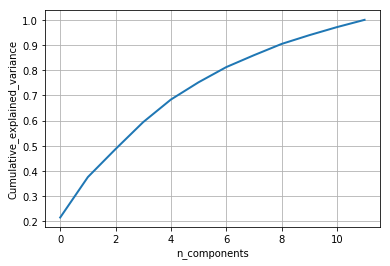

In [17]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

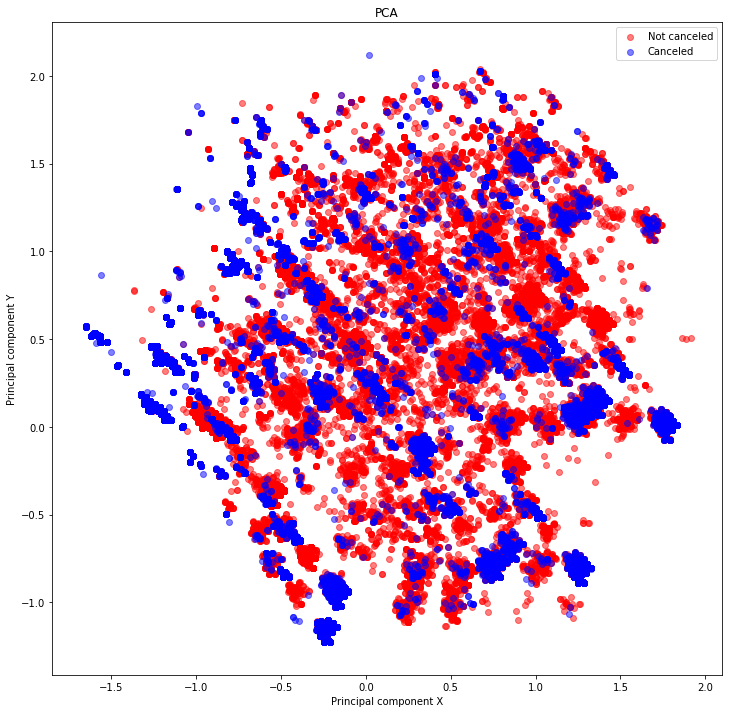

In [18]:
pca = PCA(n_components=len(df_cat.columns))

# Perform PCA on the one-hot encoded labels
X_pca = pca.fit_transform(onehotlabels)

# Rebuild it in its original dimension
X_pca_reconst = pca.inverse_transform(X_pca)

#plotting

plt.figure(figsize=(12,12))

plt.scatter(X_pca[y_cat==0, 0], X_pca[y_cat==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_pca[y_cat==1, 0], X_pca[y_cat==1, 1], color='blue', alpha=0.5,label='Canceled')

plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

## 3.2 Categorical features only

In [19]:
#getting the numerical feature columns one more time
cols = df.columns
num_cols = df._get_numeric_data().columns

#selecting numerical features
df_num=df[num_cols]

#selecting target ('is_canceled' column)
y_num=y_cat

In [20]:
df_num=df_num.fillna(df_num.median())

In [21]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
df_num_standard = StandardScaler().fit_transform(df_num.values)

#replacing the X_num dataframe with the standardized dataframe
df_num[:] = df_num_standard

In [22]:
df_num.head().transpose()

,0,1,2,3,4
lead_time,2.227051,5.923385,-0.907814,-0.851667,-0.842309
arrival_date_year,-1.634768,-1.634768,-1.634768,-1.634768,-1.634768
arrival_date_week_number,-0.012141,-0.012141,-0.012141,-0.012141,-0.012141
arrival_date_day_of_month,-1.685297,-1.685297,-1.685297,-1.685297,-1.685297
stays_in_weekend_nights,-0.928890,-0.928890,-0.928890,-0.928890,-0.928890
stays_in_week_nights,-1.310240,-1.310240,-0.786207,-0.786207,-0.262174
adults,0.247897,0.247897,-1.478447,-1.478447,0.247897
children,-0.260659,-0.260659,-0.260659,-0.260659,-0.260659
babies,-0.081579,-0.081579,-0.081579,-0.081579,-0.081579
is_repeated_guest,-0.181560,-0.181560,-0.181560,-0.181560,-0.181560


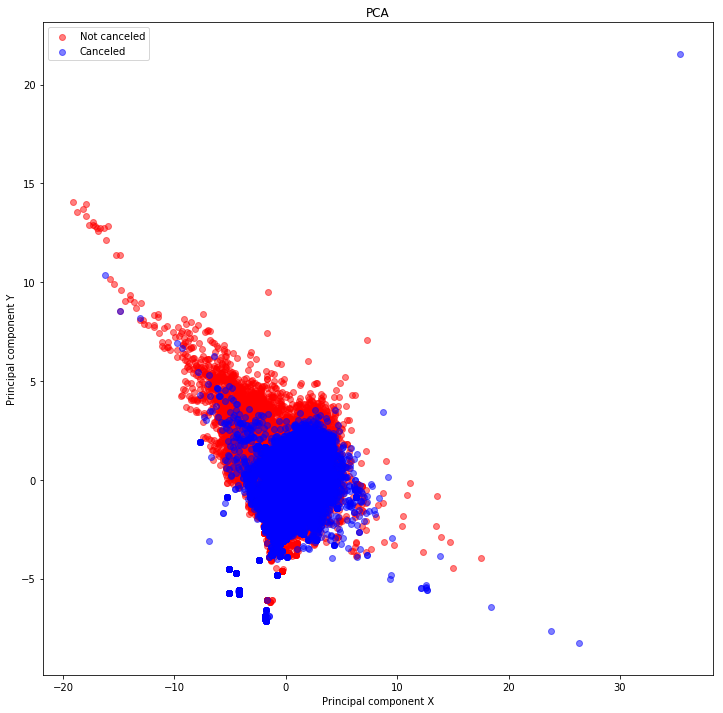

In [23]:
pca = PCA(n_components=len(df_num.columns))

# Perform PCA on the one-hot encoded labels
df_pca_num = pca.fit_transform(df_num)

#plotting

plt.figure(figsize=(12,12))

plt.scatter(df_pca_num[y_num==0, 0], df_pca_num[y_num==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(df_pca_num[y_num==1, 0], df_pca_num[y_num==1, 1], color='blue', alpha=0.5,label='Canceled')

plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

# 4 数据接口，可直接替换下面代码

In [24]:
#concatenating numerically converted categorical and numerical feature arrays
X_arr=np.concatenate((onehotlabels, df_num_standard), axis=1)
y_arr = df['is_canceled'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_arr,y_arr,test_size=0.25,random_state=2019)